In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk

from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import DataLoader, TensorDataset


%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. LOAD THE TRAINING TEXT

In [3]:
train_data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets and models/train.csv')
test_data_sub=pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets and models/test.csv')

reviews=train_data['review']
labels=train_data['sentiment'].values

input_test=test_data_sub['review']
y_test=list()

## 2. TEXT PRE-PROCESSING

In [4]:
nltk.download("stopwords")
stop_words = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [6]:
def review_formatting(reviews):
    all_reviews=list()
    for text in reviews:
        lower_case = text.lower()
        words = lower_case.split()
        reformed = [appos[word] if word in appos else word for word in words]
        reformed_test=list()
        for word in reformed:
            if word not in stop_words:
                reformed_test.append(word)
        reformed = " ".join(reformed_test) 
        punct_text = "".join([ch for ch in reformed if ch not in punctuation])
        all_reviews.append(punct_text)
    all_text = " ".join(all_reviews)
    all_words = all_text.split()
    return all_reviews, all_words

In [7]:
all_reviews, all_words = review_formatting(reviews)

In [8]:
print(all_words[0:20])


['done', 'lot', 'international', 'travel', 'business', 'tourist', 'types', 'assure', 'best', 'advice', 'also', 'oldest', 'always', 'drink', 'wine', 'country', 'movie', 'archangel', 'michael', 'comes']


In [9]:
print(all_reviews[0:1]) # single sentence

['done lot international travel business tourist types assure best advice also oldest always drink wine country movie archangel michael comes earth business wraps quickly decides hang around little touring boy drink wine countrybr br could man drunk forever liquor love fights br br hed lief rise mornings lief lie nightsbr br these things cannot heaven enjoys he is here course turns couple jobs tackle and less direct first one successful final scene little schmaltzy also wonderful jean stapleton gets dance john travolta']


In [10]:
# Count all the words using Counter Method
all_reviews, all_words=review_formatting(reviews)
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)

In [11]:
# Create a dictionary to convert words to Integers based on the number of occurrence of the word

vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
#print(vocab_to_int)
print(vocab_to_int['the'])

11


### Encoding reviews

In [12]:
# Encode review in to list of Integer by using above dictionary
def encode_reviews(reviews):
    """
    encode_reviews function will encodes review in to array of numbers
    """
    all_reviews=list()
    for text in reviews:
        text = text.lower()
        text = "".join([ch for ch in text if ch not in punctuation])
        all_reviews.append(text)
    encoded_reviews=list()
    for review in all_reviews:
        encoded_review=list()
        for word in review.split():
            if word not in vocab_to_int.keys():
                encoded_review.append(0)
            else:
                encoded_review.append(vocab_to_int[word])
        encoded_reviews.append(encoded_review)
    return encoded_reviews

In [13]:
def pad_sequences(encoded_reviews, sequence_length=250):
    ''' 
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features=np.zeros((len(encoded_reviews), sequence_length), dtype=int)
    
    for i, review in enumerate(encoded_reviews):
        review_len=len(review)
        if (review_len<=sequence_length):
            zeros=list(np.zeros(sequence_length-review_len))
            new=zeros+review
        else:
            new=review[:sequence_length]
        features[i,:]=np.array(new)
    return features

In [14]:
def preprocess(reviews):
    """
    This Function will tranform reviews in to model readable form
    """
    formated_reviews, all_words = review_formatting(reviews)
    encoded_reviews=encode_reviews(formated_reviews)
    features=pad_sequences(encoded_reviews, 250)
    return features

### Analyze The Review Length

In [15]:
encoded_reviews=encode_reviews(reviews)
review_len=[len(encoded_review) for encoded_review in encoded_reviews]

In [16]:
print(encoded_reviews[0])
print()
print(len(encoded_reviews[0]))

[59, 53, 139, 230, 86, 609, 1816, 2006, 1912, 236, 924, 98, 324, 230, 4173, 449, 1912, 2073, 59, 6068, 46, 11, 43, 1872, 4, 22, 11, 6189, 119, 2763, 11, 3942, 609, 11, 608, 164, 54, 2, 11, 27083, 417, 172, 451, 657, 236, 924, 10979, 6, 351, 849, 98, 976, 451, 2987, 104, 449, 230, 42, 13640, 357, 67, 103, 2763, 11, 3942, 609, 11, 11683, 1, 21, 60, 574, 2068, 1416, 429, 11455, 41, 98, 1747, 1, 1, 31405, 43646, 2042, 351, 609, 24040, 98, 43646, 2621, 875, 609, 38236, 1, 2764, 64, 96, 46, 1511, 25, 164, 2021, 257, 103, 4190, 196, 970, 3843, 215, 609, 170, 6, 422, 242, 103, 285, 230, 272, 609, 684, 2718, 451, 8404, 98, 359, 103, 4, 258, 1530, 698, 196, 9953, 103, 121, 698, 11, 27, 7, 103, 4, 1621, 324, 1048, 11, 368, 58, 4, 230, 42, 14030, 231, 6, 4, 22, 298, 1748, 15217, 120, 451, 780, 429, 220, 5509]

163


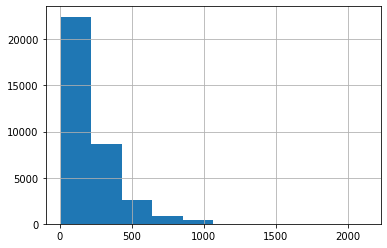

count    35000.000000
mean       230.740571
std        171.009115
min          8.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2122.000000
dtype: float64

In [17]:
pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

In [18]:
#split_dataset into 80% training , 10% test and 10% Validation Dataset
features=preprocess(reviews)
train_x=features[:int(0.90*len(features))]
train_y=labels[:int(0.90*len(features))]
valid_x=features[int(0.90*len(features)):]
valid_y=labels[int(0.90*len(features)):]

In [19]:
print(len(train_y), len(valid_y))

31500 3500


In [20]:
train_x.shape

(31500, 250)

In [21]:
train_x[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [22]:
print(train_x[0].shape)

(250,)


In [23]:
# Create Tensor Dataset

train_data=TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data=TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))

In [24]:
train_data

In [25]:
# Dataloader
batch_size = 64

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [26]:
# obtain one batch of training data

data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 250])
Sample input: 
 tensor([[    0,     0,     0,  ...,   253, 62938, 15143],
        [    0,     0,     0,  ...,   314,   179,   217],
        [    0,     0,     0,  ...,     3,    10,     9],
        ...,
        [    0,     0,     0,  ...,   632,   464,  8897],
        [    0,     0,     0,  ...,    11, 11649,   176],
        [    0,     0,     0,  ...,   902,    77,   738]])
Sample label size:  torch.Size([64])
Sample label: 
 tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1])


## 2) Building Model

In [27]:
class Model(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embedding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd)
        
        #stack up the lstm output(dimension reduction)(batch, sequence_len, emd_dim)
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #(batch x sequence_len, emb_dim)
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    

In [28]:
# Instantiate the model w/ hyperparams

vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

In [29]:
net = Model(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)net = Model(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

Model(
  (embedding): Embedding(148794, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
# Train the model
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [31]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [32]:
# training params

epochs = 3 
counter = 0
print_every = 100
clip=5 # gradient clipping

In [33]:
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

In [34]:
net.train()

Model(
  (embedding): Embedding(148794, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# train for some number of epochs
for e in range(epochs):
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()


        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                inputs, labels = inputs.cuda(), labels.cuda()  
                output, val_h = net(inputs)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 200... Loss: 0.553945... Val Loss: 0.529854
Epoch: 1/3... Step: 300... Loss: 0.538525... Val Loss: 0.504360
Epoch: 1/3... Step: 400... Loss: 0.628530... Val Loss: 0.477771
Epoch: 1/3... Step: 500... Loss: 0.376904... Val Loss: 0.400399
Epoch: 2/3... Step: 600... Loss: 0.378838... Val Loss: 0.396332
Epoch: 2/3... Step: 700... Loss: 0.252393... Val Loss: 0.365861
Epoch: 2/3... Step: 800... Loss: 0.282139... Val Loss: 0.335598
Epoch: 2/3... Step: 900... Loss: 0.371741... Val Loss: 0.327036
Epoch: 2/3... Step: 1000... Loss: 0.241521... Val Loss: 0.311309
Epoch: 3/3... Step: 1100... Loss: 0.175226... Val Loss: 0.370784
Epoch: 3/3... Step: 1200... Loss: 0.133640... Val Loss: 0.349609
Epoch: 3/3... Step: 1300... Loss: 0.088199... Val Loss: 0.359517
Epoch: 3/3... Step: 1400... Loss: 0.174076... Val Loss: 0.300363
Epoch: 3/3... Step: 1500... Loss: 0.266334... Val Loss: 0.322321


In [ ]:
def test_model(input_test):
    output_list=list()
    batch_size=50   
    net.eval()
    with torch.no_grad():
        test_review=preprocess(input_test)
        for review in test_review:
            # convert to tensor to pass into your model
            feature_tensor = torch.from_numpy(review).view(1,-1)
            if(train_on_gpu):
                feature_tensor= feature_tensor.cuda()
            batch_size = feature_tensor.size(0)
            # get the output from the model
            output, h = net(feature_tensor)
            pred = torch.round(output.squeeze()) 
            output_list.append(pred)
        labels=[int(i.data.cpu().numpy()) for i in output_list]
        return labels

In [ ]:
labels=test_model(input_test)

In [ ]:
print(labels)

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 

### Loading Pretrained GloVe Embedding

In [41]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-22 10:30:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-22 10:30:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-22 10:30:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [42]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [43]:
def load_glove_vectors(glove_file="./glove.6B.50d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [44]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [65]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, count_words)

In [82]:
class Model_Pretrained_GloVe(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, glove_weights, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embedding.weight.requires_grad = False ## freeze embeddings

        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embedding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd)
        
        #stack up the lstm output(dimension reduction)(batch, sequence_len, emd_dim)
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #(batch x sequence_len, emb_dim)
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    

In [84]:
# Instantiate the model w/ hyperparams

vocab_size = len(vocab_to_int) + 2 # +1 for the 0 padding
output_size = 1
embedding_dim = 50
hidden_dim = 256
n_layers = 2

In [85]:
net = Model_Pretrained_GloVe(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_weights)
print(net)

Model_Pretrained_GloVe(
  (embedding): Embedding(148795, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [86]:
# Train the model
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [87]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [88]:
# training params

epochs = 3 
counter = 0
print_every = 100
clip=5 # gradient clipping

In [89]:
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

In [90]:
net.train()

Model_Pretrained_GloVe(
  (embedding): Embedding(148795, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [91]:
# train for some number of epochs
for e in range(epochs):
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()


        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:


                inputs, labels = inputs.cuda(), labels.cuda()  
                output, val_h = net(inputs)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 0.686071... Val Loss: 0.691718
Epoch: 1/3... Step: 200... Loss: 0.684819... Val Loss: 0.684735
Epoch: 1/3... Step: 300... Loss: 0.687802... Val Loss: 0.685403
Epoch: 1/3... Step: 400... Loss: 0.663718... Val Loss: 0.670875
Epoch: 2/3... Step: 500... Loss: 0.690176... Val Loss: 0.685817
Epoch: 2/3... Step: 600... Loss: 0.696235... Val Loss: 0.665202
Epoch: 2/3... Step: 700... Loss: 0.645232... Val Loss: 0.654329
Epoch: 2/3... Step: 800... Loss: 0.599421... Val Loss: 0.631977
Epoch: 2/3... Step: 900... Loss: 0.647857... Val Loss: 0.629403
Epoch: 3/3... Step: 1000... Loss: 0.611636... Val Loss: 0.586737
Epoch: 3/3... Step: 1100... Loss: 0.593007... Val Loss: 0.618367
Epoch: 3/3... Step: 1200... Loss: 0.594088... Val Loss: 0.625557
Epoch: 3/3... Step: 1300... Loss: 0.690113... Val Loss: 0.690277
Epoch: 3/3... Step: 1400... Loss: 0.657750... Val Loss: 0.673978
